## Forecasting forex using ARIMA for USD/VND 
The purpose of this research is to forecast usd/vnd exchamge rate to use in our investment analysis.

# Import packages

In [2]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas import DataFrame
from pandas_datareader import data as wb
from matplotlib import pyplot

from pmdarima.arima import auto_arima
from datetime import datetime
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]

## Input data

C:\Users\User\AppData\Local\Temp\ipykernel_27608\1806183337.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filepath, parse_dates=['Date'])


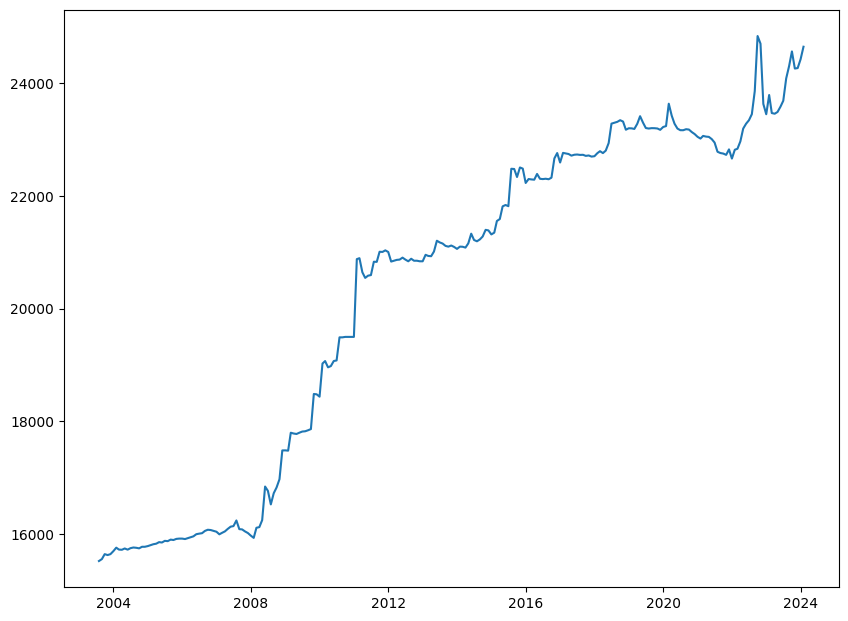

In [20]:
# Filepath to the CSV file
filepath = r"C:\Users\User\Desktop\Clone git\FinalisedData.csv"

# Read the CSV file, specifying the date format
data = pd.read_csv(filepath, parse_dates=['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Retaining only wanted data
data = data[['FX Rate']]

# Drop rows with NaN values
data.dropna(inplace=True)

# Format data
data.index = pd.to_datetime(data.index, format='%b-%y')
data = data.sort_index()

# Plot data
plt.plot(data)

## Stationary test

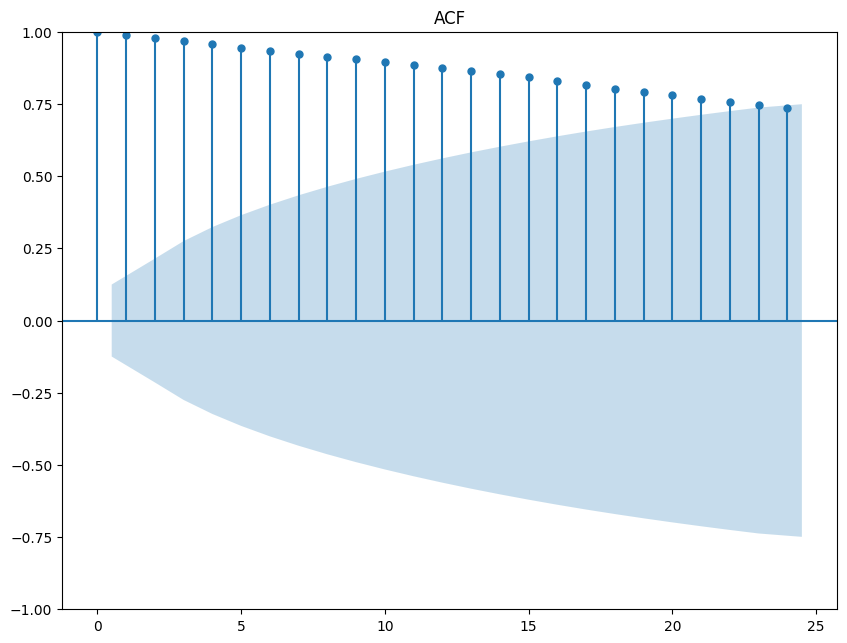

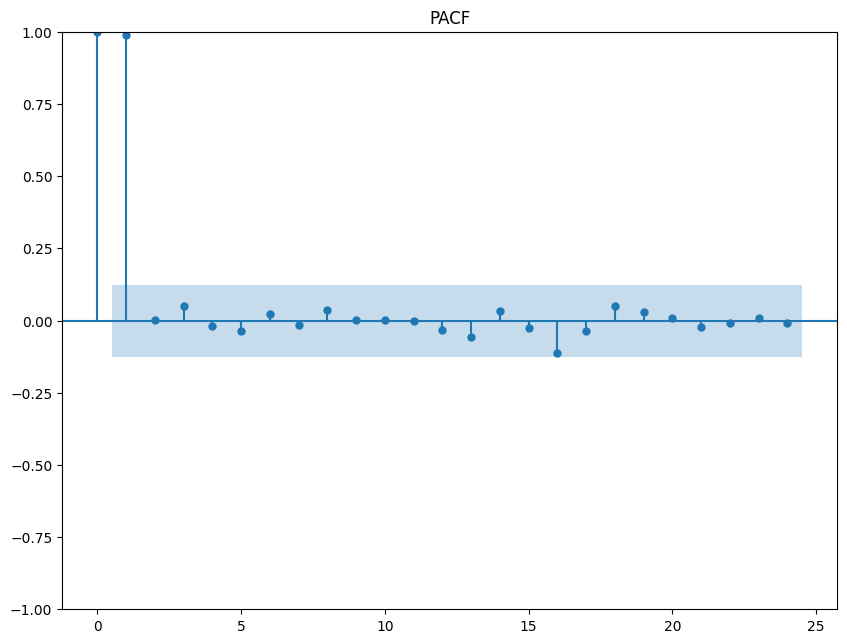

In [10]:
# Autocorrelation and partial correlation function of data
plot_acf(data)
plt.title("ACF")
plot_pacf(data)
plt.title("PACF")
plt.show()

In [21]:
adftest = adfuller(data, autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")


ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -1.4575049947224368
P-Value: 0.8432337779612686
Number of lags: 11
Number of observations: 235
Critical Values: {'1%': -3.997818933858586, '5%': -3.4293396709977557, '10%': -3.13812535054853}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


## Differencing 

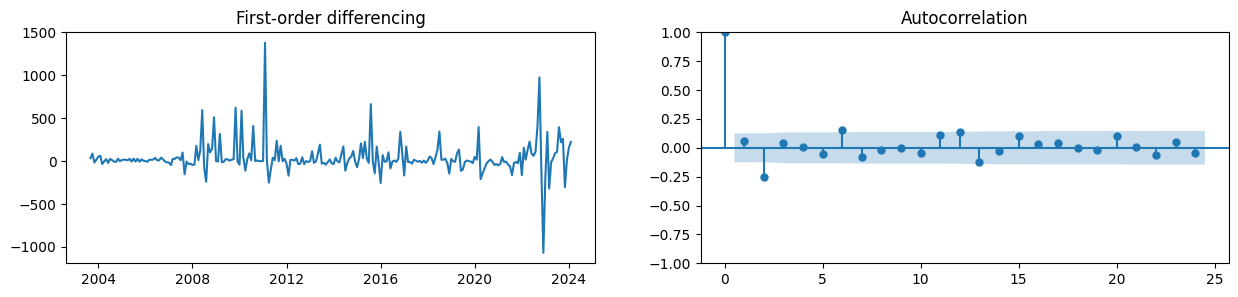

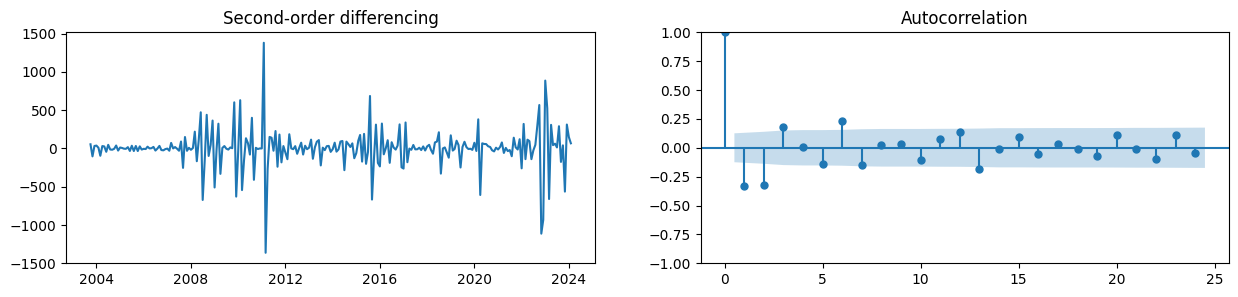

In [22]:
# First-order differencing
data['diff1'] = data.diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('First-order differencing')
ax1.plot(data['diff1'])

data['growth_1'] = data['diff1']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(data['diff1'].dropna(), ax=ax2)
plt.show()

# Second order differencing
data['diff2'] = data['FX Rate'].diff().diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('Second-order differencing')
ax1.plot(data['diff2'])

data['growth_2'] = data['diff2']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(data['diff2'].dropna(), ax=ax2)
plt.show()



In [25]:
# Test stationarity with ADF
adftest = adfuller(data['growth_1'].dropna(), autolag = 'AIC', regression = 'n')
print("ADF Test Results")
print("Null Hypothesis: The series has an Unit Root")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary")


ADF Test Results
Null Hypothesis: The series has an Unit Root
ADF-Statistic: -3.1806031971717004
P-Value: 0.0014706193449056414
Number of lags: 10
Number of observations: 235
Critical Values {'1%': -2.5753197193300137, '5%': -1.9422015054082429, '10%': -1.6157369772401105}
Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary


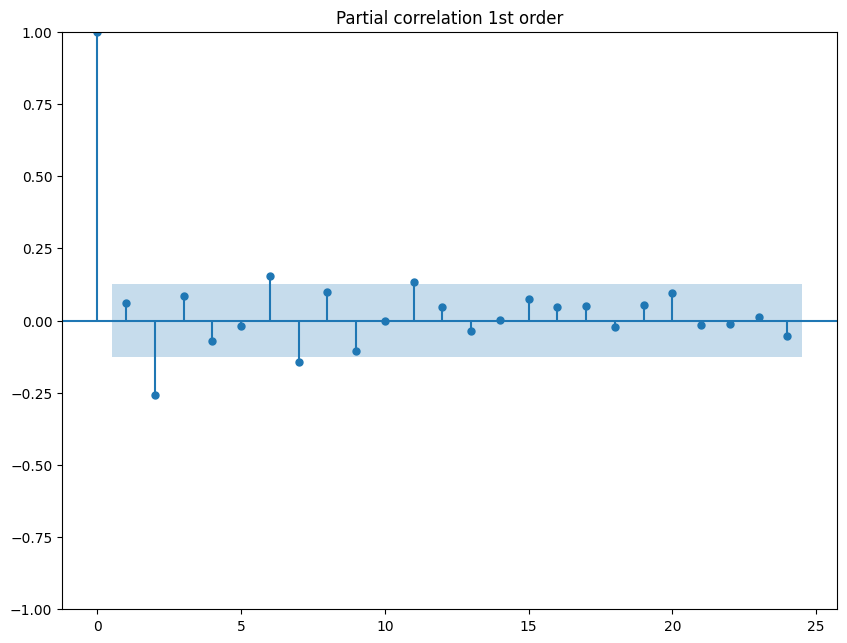

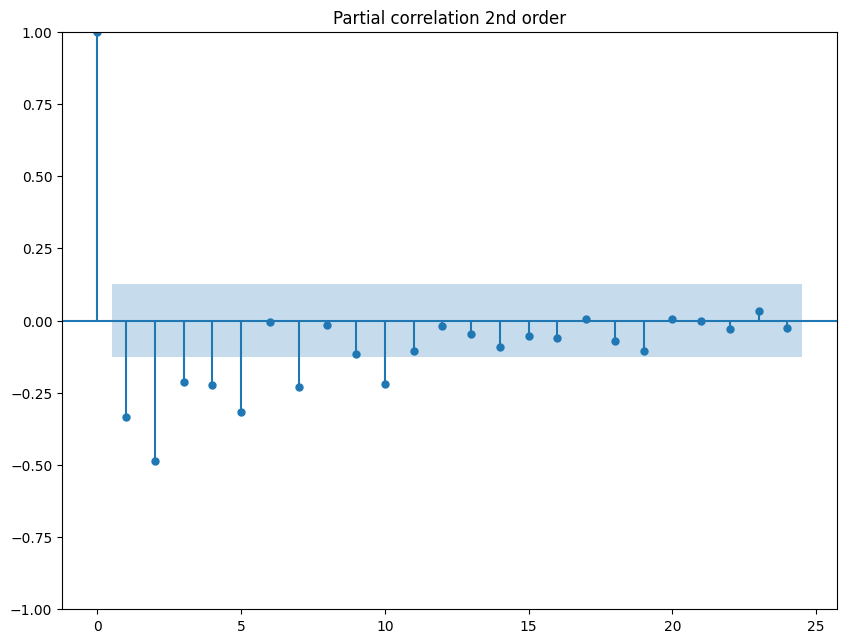

In [26]:
# Partial autocorrelation
plot_pacf(data['diff1'].dropna(),method='ywm')
plt.title('Partial correlation 1st order')
plt.show()

plot_pacf(data['diff2'].dropna(),method='ywm')
plt.title('Partial correlation 2nd order')
plt.show()

# ARIMA model parameters

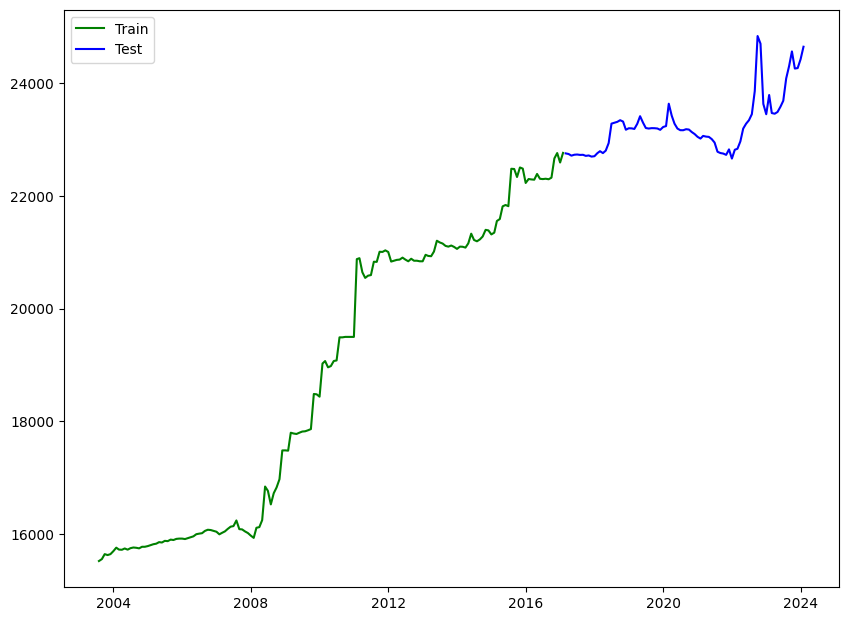

In [32]:
# Seperate into train and test data
to_row = int(len(data)*0.66)

df_train = list(data[0:to_row]['FX Rate'])
df_test = list(data[to_row:]['FX Rate'])

# Plot
plt.plot(data[0:to_row]['FX Rate'], 'green', label='Train')
plt.plot(data[to_row:]['FX Rate'],'blue',label='Test')
plt.legend()
plt.show()

In [33]:
# Finding ARIMA parameters automatically
model = auto_arima(data[0:to_row]['diff1'].dropna(), seasonal=False, stepwise= False, d= None, suppress_warnings=True)
print(model.order)

(2, 0, 2)


In [36]:
model_predictions = []
n_test_obser = len(df_test)

p = 2
d = 0
q = 2

for i in range(n_test_obser):
    model = ARIMA(df_train, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)
    model_predictions.append(yhat)
    actual_test_value = df_test[i]
    df_train.append(actual_test_value)

In [37]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  330
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2242.913
Date:                Tue, 16 Apr 2024   AIC                           4497.826
Time:                        06:20:21   BIC                           4520.620
Sample:                             0   HQIC                          4506.918
                                - 330                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.106e+04   5600.652      3.761      0.000    1.01e+04     3.2e+04
ar.L1          1.0563      0.348      3.033      0.002       0.374       1.739
ar.L2         -0.0574      0.348     -0.165      0.869      -0.738       0.624
ma.L1          0.0336      0.339      0.099      0.921      -0.632       0.699
ma.L2         -0.1739      0.040     -4.341      0.000      -0.252      -0.095
sigma2      4.604e+04   1137.647     40.472      0.000    4.38e+04    4.83e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             10626.19
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               2.44   Skew:                            -1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

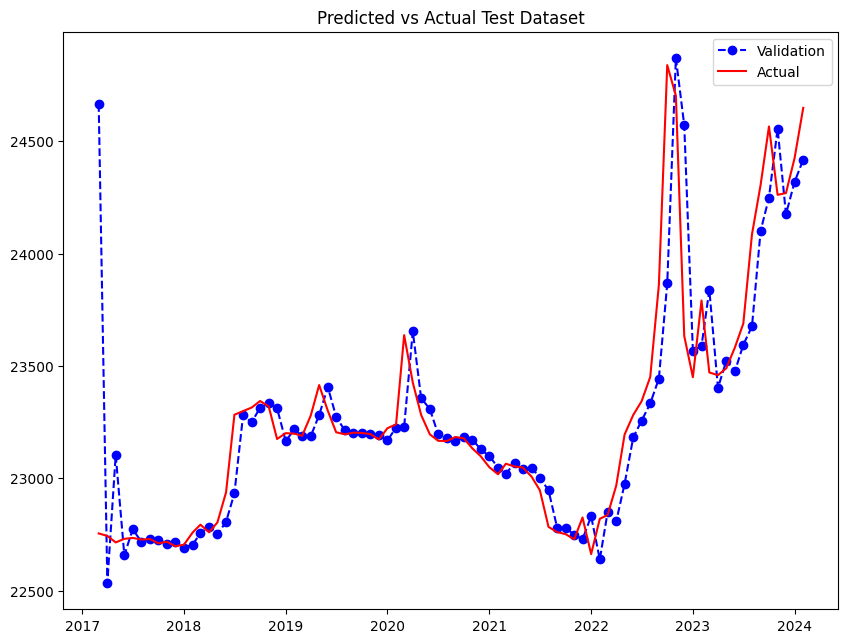

In [39]:
date_range = data[to_row:].index
plt.plot(date_range, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(date_range, df_test, color = 'red', label = 'Actual')
plt.legend()
plt.title('Predicted vs Actual Test Dataset')
plt.show()

# Evaluate model predictions

In [41]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, model_predictions)
mape = mean_absolute_percentage_error(df_test, model_predictions)
mse = (mean_squared_error(df_test, model_predictions))
rmse = np.sqrt(mean_squared_error(df_test, model_predictions))

print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 141.2179817014409
mse: 86082.8201076971
mape: 0.00601682440977575
rmse: 293.39873910379555


In [43]:
testScore = np.sqrt(mean_squared_error(df_test, model_predictions))

testScore = testScore

print('Test Score: %.6f RMSE' % (testScore))

rmspe = (np.sqrt(np.mean(np.square(np.subtract(df_test,model_predictions) / df_test)))) * 100
print('Test Score: %.6f RMSPE' % (rmspe))

Test Score: 293.398739 RMSE
Test Score: 3.033389 RMSPE


# Forecast into the future

In [44]:
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

print("Forecasted values:")
print(forecast)

Forecasted values:
[24417.79098943 24395.61787595 24390.90343677 24387.19514517
 24383.54838887 24379.9089296  24376.27364919 24372.64236451
 24369.01506091 24365.39173344 24361.77237771 24358.15698936]


In [51]:
from pandas.tseries.offsets import DateOffset

future_dates = [data.index[-1] + DateOffset(months = x) for x in range (0,forecast_steps+1)]
future_dates_df = pd.DataFrame(index = future_dates[1:], columns = data.columns)
comb_df = pd.concat([data[to_row:], future_dates_df])

C:\Users\User\AppData\Local\Temp\ipykernel_27608\3607671743.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comb_df = pd.concat([data[to_row:], future_dates_df])


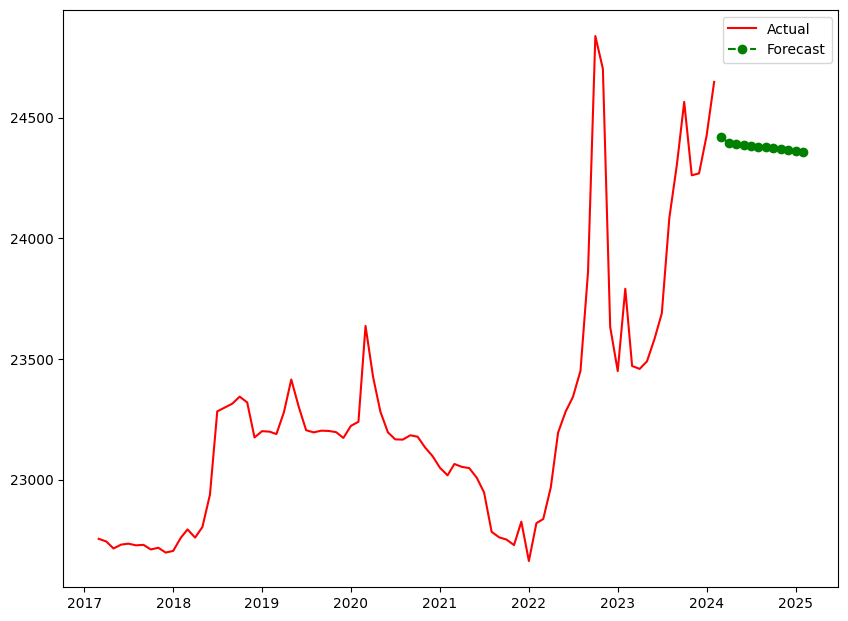

In [52]:
plt.plot(data[to_row:].index, data[to_row:]['FX Rate'], color = 'red', label = 'Actual')
plt.plot(future_dates_df.index, forecast, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Forecast')
plt.legend()

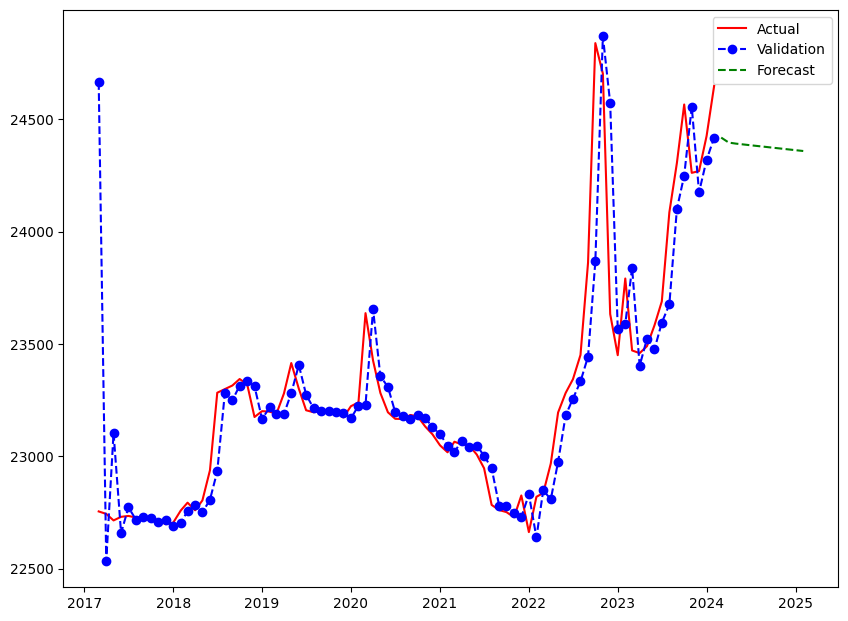

In [56]:
plt.plot(data[to_row:].index, data[to_row:]['FX Rate'], color = 'red', label = 'Actual')
plt.plot(data[to_row:].index, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(future_dates_df.index, forecast, color = 'green', linestyle = 'dashed', label = 'Forecast')
plt.legend()

# Check fit